In [1]:
import os
import sys
os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={os.cpu_count()}"
sys.path.append('../')
import jax
from jax import vmap, jit, grad, random, jacfwd
from jax.lax import map
import jax.numpy as jnp
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import warnings
from jax import config
config.update("jax_enable_x64", True)
import numpyro
numpyro.enable_x64()
from gwb.omega_gw_jax import OmegaGWjax
from interpolation.spline import Spline
from inference.numpyro_model import model
from inference.numpyro_infer import NumpyroInference
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


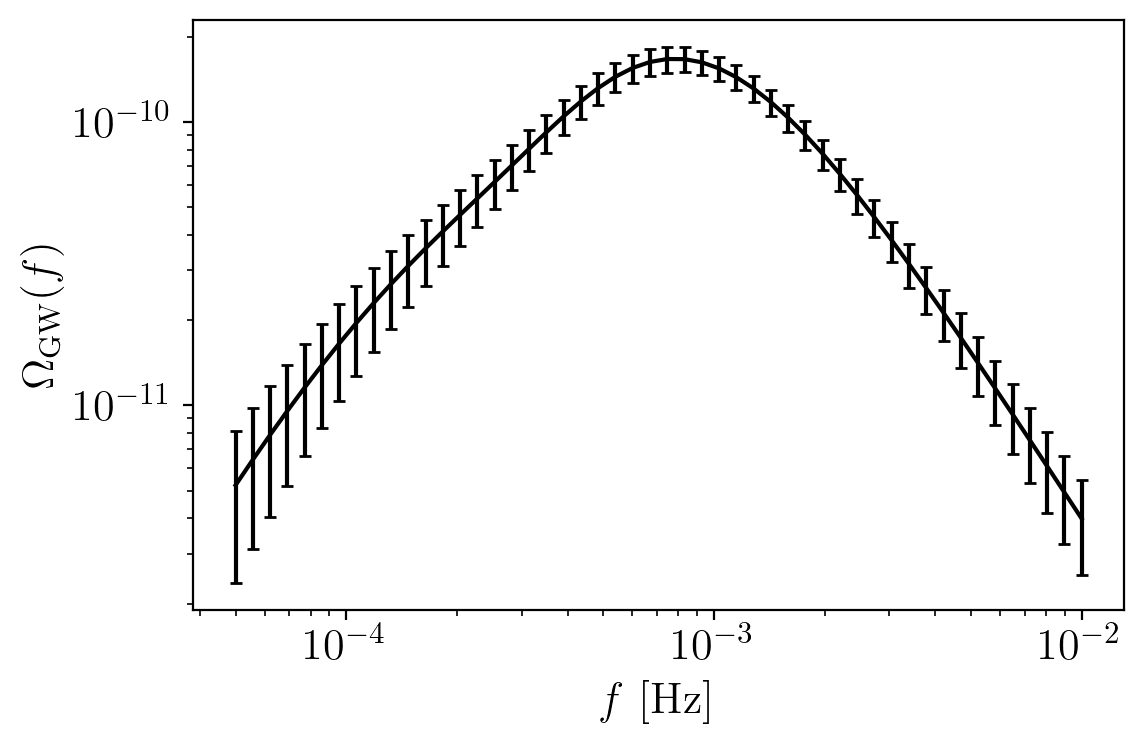

In [2]:
# load the gwb data from file and plot it
data = np.load('../bpl_data.npz')
frequencies = data['k']
Omegas = data['gw']
cov = data['cov']
p_arr = data['p_arr']
pz_amp = data['pz_amp']

plt.figure(figsize=(6,4))
plt.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$\Omega_{\rm GW}(f)$')
plt.tight_layout()

In [ ]:
# set up the interpolator
# fac = 10
num_nodes = 5
pk_min, pk_max = min(p_arr), max(p_arr) # jnp.array(min(frequencies)/fac), jnp.array(max(frequencies)*fac)
interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=False,fixed_nodes=None,num_nodes=num_nodes)

# set up the gwb calculator
s = jnp.linspace(0, 1, 15)  # First rescaled internal momentum
t = jnp.logspace(-5,5, 150)  # Second rescaled internal momentum
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(frequencies), axis=-1)

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh
from jax.experimental import mesh_utils
    
# mesh2d = jax.make_mesh((8, 1), ('x', 'y'))
# devices = mesh_utils.create_device_mesh((jax.device_count(),))  # 1D mesh
# # Step 2: Create a mesh and named sharding strategy
# mesh = Mesh(devices, axis_names=('x',))  # Name the axis "x"
# sharding = NamedSharding(mesh, P('x'))  # Distribute along 'x'
# s = jnp.linspace(0, 1, 96)  # First rescaled internal momentum
# ss = jax.device_put(s, sharding) #NamedSharding(mesh1d, P('x')))
# s = jnp.linspace(0, 1, 25)
# t = jnp.logspace(-5,5, 1800)  # Second rescaled internal momentum
# freqs = jnp.array(frequencies)
# ## Expand t to add a new axis
# t_expanded = jnp.expand_dims(t, axis=-1)
# ## Repeat t along the new axis to match the shape (ns,nt)
# t = jnp.repeat(t_expanded, len(freqs), axis=-1)


gwb_calculator = OmegaGWjax(s,t,frequencies,norm="RD",kernel="RD")



In [ ]:
# set up the inference for fixed nodes
fixed_nodes = jnp.linspace(0,1,num_nodes)
model_args = {'num_nodes':num_nodes,  'pk_bounds': [jnp.log10(pk_min),jnp.log10(pk_max)],
              'sample_nodes': False, 'fixed_nodes': fixed_nodes, 'amp_bounds': [-6,-2],
              'interpolator': interpolator, 'gwb_calculator': gwb_calculator,
             }
sampler = NumpyroInference(model,model_args=model_args
                           ,num_samples=256,num_warmup=256,
                          )

samples, extras = sampler.run_inference(frequencies=frequencies,data=Omegas,cov=cov)

[-5.30103   -4.2257725 -3.150515  -2.0752575 -1.       ]


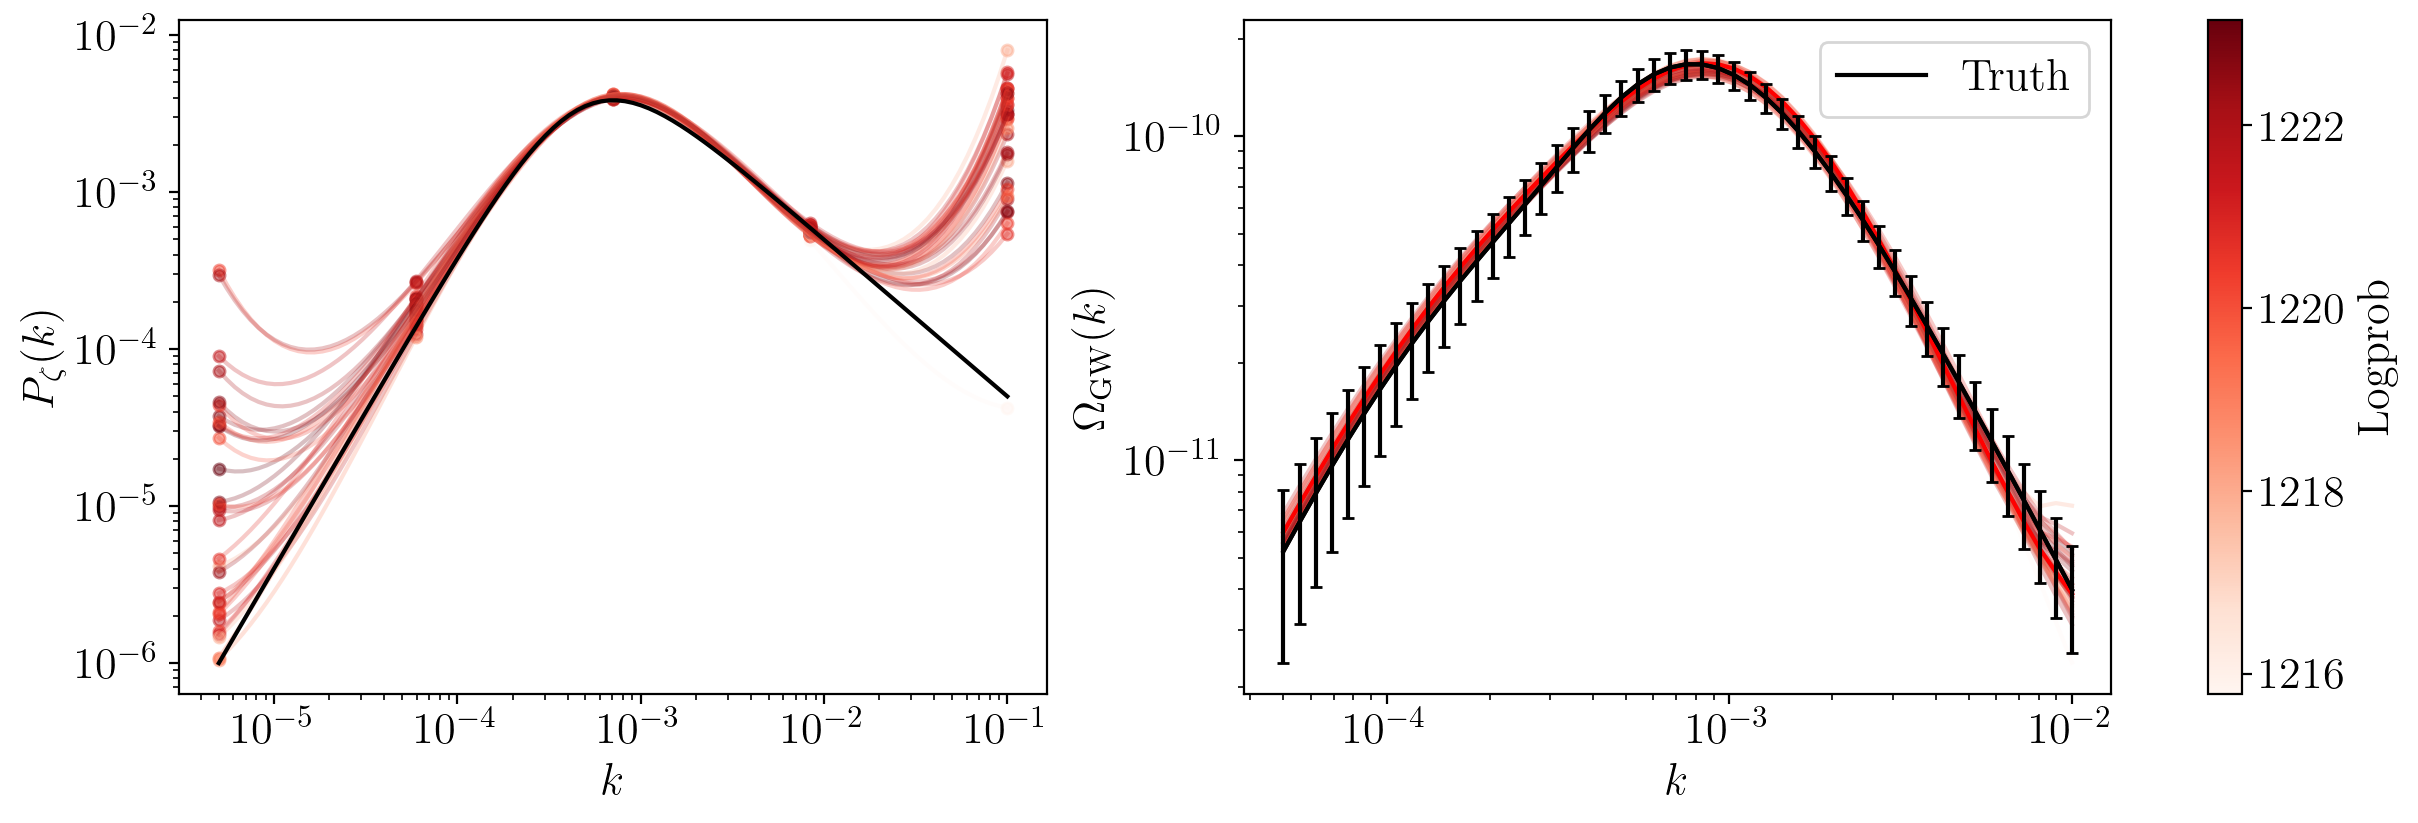

In [ ]:
### Plot the MC realisations with their logprob

from interpolation.spline import spline_predict
# p_arr = jnp.geomspace(pk_min*1.001,pk_max*0.999,100,endpoint=True)

thinning = 16
cmap = matplotlib.colormaps['Reds']
ys = samples['values'][::thinning]
xs = interpolator.fixed_nodes
print(xs)
lp = -extras["potential_energy"][::thinning] # PE = -logprob
lp_min, lp_max = np.min(lp), np.max(lp)
cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')

def get_pz_omega(y):
    pf = interpolator.interpolate(xs, y)
    pz_amps = pf(p_arr)
    gwb_res = gwb_calculator(pf,frequencies)
    return pz_amps, gwb_res

pz_amps,gwb_amps = vmap(get_pz_omega)(ys)
# print(pz_amps[2])

for i,ps in enumerate(pz_amps):
    ax1.loglog(p_arr,ps,alpha=0.25,color=cmap(cols[i]))
    ax1.scatter(10**(xs),10**(ys[i]),s=16,alpha=0.5,color=cmap(cols[i]))
    ax2.loglog(frequencies,gwb_amps[i],alpha=0.25,color=cmap(cols[i]))

# print(gwb_amps[1,:])

ax2.loglog(frequencies,gwb_amps[1,:],color='r',lw=1.5)
# True pz
# def pz(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
#     nir = n1
#     pl1 = (p/pstar)**nir
#     nuv = (n2 - n1)/sigma
#     pl2 = (1+(p/pstar)**sigma)**nuv
#     return 1e-2 * pl1 * pl2
# pz_amp = pz(p_arr)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')

512
(32, 100)
(32, 50)


<ErrorbarContainer object of 3 artists>

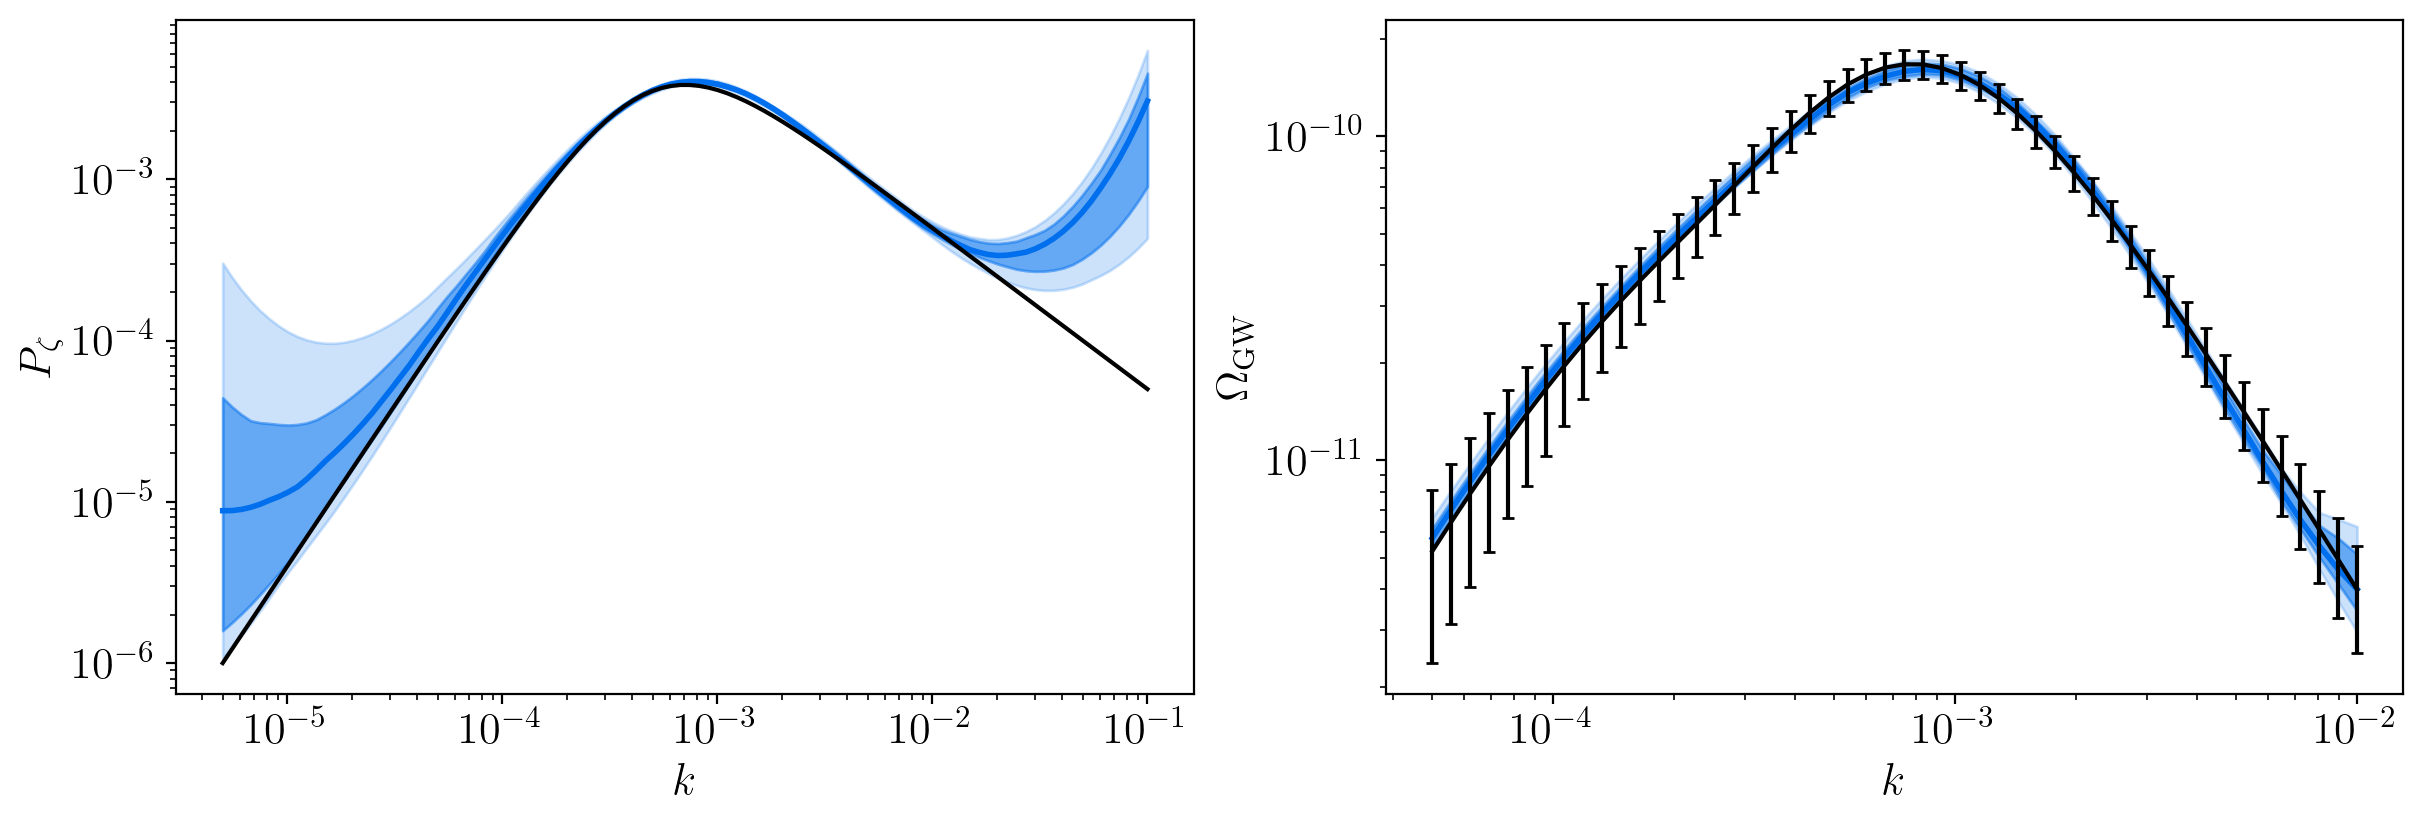

In [ ]:
# Plot the functional posterior

print(len(samples['values']))

def plot_functional_posterior(vals = [],k_arr = [], intervals = [95,68],ylabels=[r'$P_{\zeta}$',r'$\Omega_{\rm GW}$'],aspect_ratio = (6,4), interval_cols = [('#006FED',0.2),('#006FED',0.5)]):
    # given a function y = f(k|x) with x~Posterior samples, plot the posterior of y at k_arr, with symmetric credible intervals

    nfuncs = len(vals)

    fig, ax = plt.subplots(1,nfuncs,figsize=(aspect_ratio[0]*nfuncs,aspect_ratio[1]),constrained_layout=True)
    if nfuncs == 1:
        ax = [ax]
    for i,val in enumerate(vals):
        for j,interval in enumerate(intervals):
            y_low, y_high = np.percentile(val,[50-interval/2,50+interval/2],axis=0)
            ax[i].fill_between(k_arr[i],y_low,y_high,color=interval_cols[j])
        ax[i].plot(k_arr[i],np.median(val,axis=0),color='#006FED',lw=2)
        ax[i].set_ylabel(ylabels[i])
    for x in ax:
        x.set(xscale='log',yscale='log',xlabel=r'$k$')
    return fig, ax 


gd_colors = ['#006FED', '#E03424']

# def get_pz(k,y):
#     pf = interpolator.interpolate(xs, y)
#     pz_amps = pf(k)
#     return pz_amps
# def get_gw(k,y):
#     pf = interpolator.interpolate(xs, y)
#     gwb_res = gwb_calculator(pf,k)
#     return gwb_res
thinning = 2
samples['values'][::thinning]
pz_amps,gwb_amps = vmap(get_pz_omega)(ys)

print(pz_amps.shape)
print(gwb_amps.shape)

# colors = 

fig, ax = plot_functional_posterior([pz_amps,gwb_amps],k_arr=[p_arr,frequencies],aspect_ratio=(6,4))
ax[0].loglog(p_arr,pz_amp,color='k',lw=1.5)
ax[1].errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')



In [ ]:
# inference for free nodes, at the moment it is too slow, possibly due to more complicatted gradient calculations
num_nodes = 4
interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=True,fixed_nodes=None,num_nodes=num_nodes)
model_args = {'num_nodes':num_nodes,  'pk_bounds': [jnp.log10(pk_min),jnp.log10(pk_max)],
              'sample_nodes': True, 'fixed_nodes': None, 'amp_bounds': [-6,-1],
              'interpolator': interpolator, 'gwb_calculator': gwb_calculator,
             }
sampler = NumpyroInference(model,model_args=model_args
                           ,num_samples=512,num_warmup=256,
                          )

samples, extras = sampler.run_inference(frequencies=frequencies,data=Omegas,cov=cov)



In [ ]:
### Plot the MC realisations with their logprob

from interpolation.spline import spline_predict
p_arr = jnp.geomspace(pk_min*1.001,pk_max*0.999,100,endpoint=True)

thinning = 16
cmap = matplotlib.colormaps['Reds']
ys = samples['values'][::thinning]
xs = samples['nodes'][::thinning]
lp = -extras["potential_energy"][::thinning] # PE = -negative logprob
lp_min, lp_max = np.min(lp), np.max(lp)
cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')

def get_pz_omega(x,y):
    pz = interpolator.interpolate(x, y)
    pz_amps = pz(p_arr)
    gwb_res = gwb_calculator(pz,frequencies)
    return pz_amps, gwb_res

pz_amps,gwb_amps = vmap(get_pz_omega)(xs,ys)

for i,pz in enumerate(pz_amps):
    ax1.loglog(p_arr,pz,alpha=0.25,color=cmap(cols[i]))
    ax1.scatter(10**(xs[i]),10**(ys[i]),s=16,alpha=0.5,color=cmap(cols[i]))
for om in gwb_amps:
    ax2.loglog(frequencies,om,alpha=0.25,color=cmap(cols[i]))

# True pz
def pz(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    return 1e-2 * pl1 * pl2
pz_amp = pz(p_arr)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')

#### JaxNS fixed nodes

In [ ]:
# now test with jaxns
import tensorflow_probability.substrates.jax as tfp
from jaxns import NestedSampler, TerminationCondition
from jaxns import Model, Prior
from jaxns.framework.special_priors import ForcedIdentifiability
tfpd = tfp.distributions


num_nodes = 5
pk_min, pk_max = jnp.array(min(frequencies)/5), jnp.array(max(frequencies)*5)
interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=False,fixed_nodes=None,num_nodes=num_nodes)

def prior():
    y = yield Prior(tfpd.Uniform(low=-6*jnp.ones(num_nodes), high=-jnp.ones(num_nodes)), name='y')
    return y

fixed_nodes = interpolator.fixed_nodes

def likelihood(y):
    pf = interpolator.interpolate(fixed_nodes,y)
    gwb = gwb_calculator(pf,frequencies)
    return tfp.distributions.Normal(gwb, jnp.sqrt(jnp.diag(cov))).log_prob(Omegas).sum()

model = Model(prior, likelihood)
model.sanity_check(key=random.PRNGKey(0),S=100)

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


In [ ]:
exact_ns = NestedSampler(model=model, max_samples=1e4,parameter_estimation=True,verbose=False,difficult_model=False)

termination_reason, state = exact_ns(random.PRNGKey(42),term_cond=TerminationCondition(dlogZ=0.2))
results = exact_ns.to_results(termination_reason=termination_reason, state=state)
exact_ns.summary(results)

Running over 8 devices.
--------
Termination Conditions:
Reached max samples
--------
likelihood evals: 184491
samples: 9760
phantom samples: 8000
likelihood evals / sample: 18.9
phantom fraction (%): 82.0%
--------
logZ=1226.46 +- 0.41
max(logL)=1243.29
H=-14.68
ESS=20
--------
y[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
y[0]: -4.45 +- 0.84 | -5.19 / -4.77 / -3.19 | -4.95 | -4.95
y[1]: -3.382 +- 0.092 | -3.475 / -3.422 / -3.229 | -3.432 | -3.432
y[2]: -2.4211 +- 0.0065 | -2.4298 / -2.4206 / -2.4133 | -2.4174 | -2.4174
y[3]: -3.118 +- 0.023 | -3.142 / -3.119 / -3.093 | -3.102 | -3.102
y[4]: -3.16 +- 0.26 | -3.49 / -3.13 / -2.89 | -2.96 | -2.96
--------


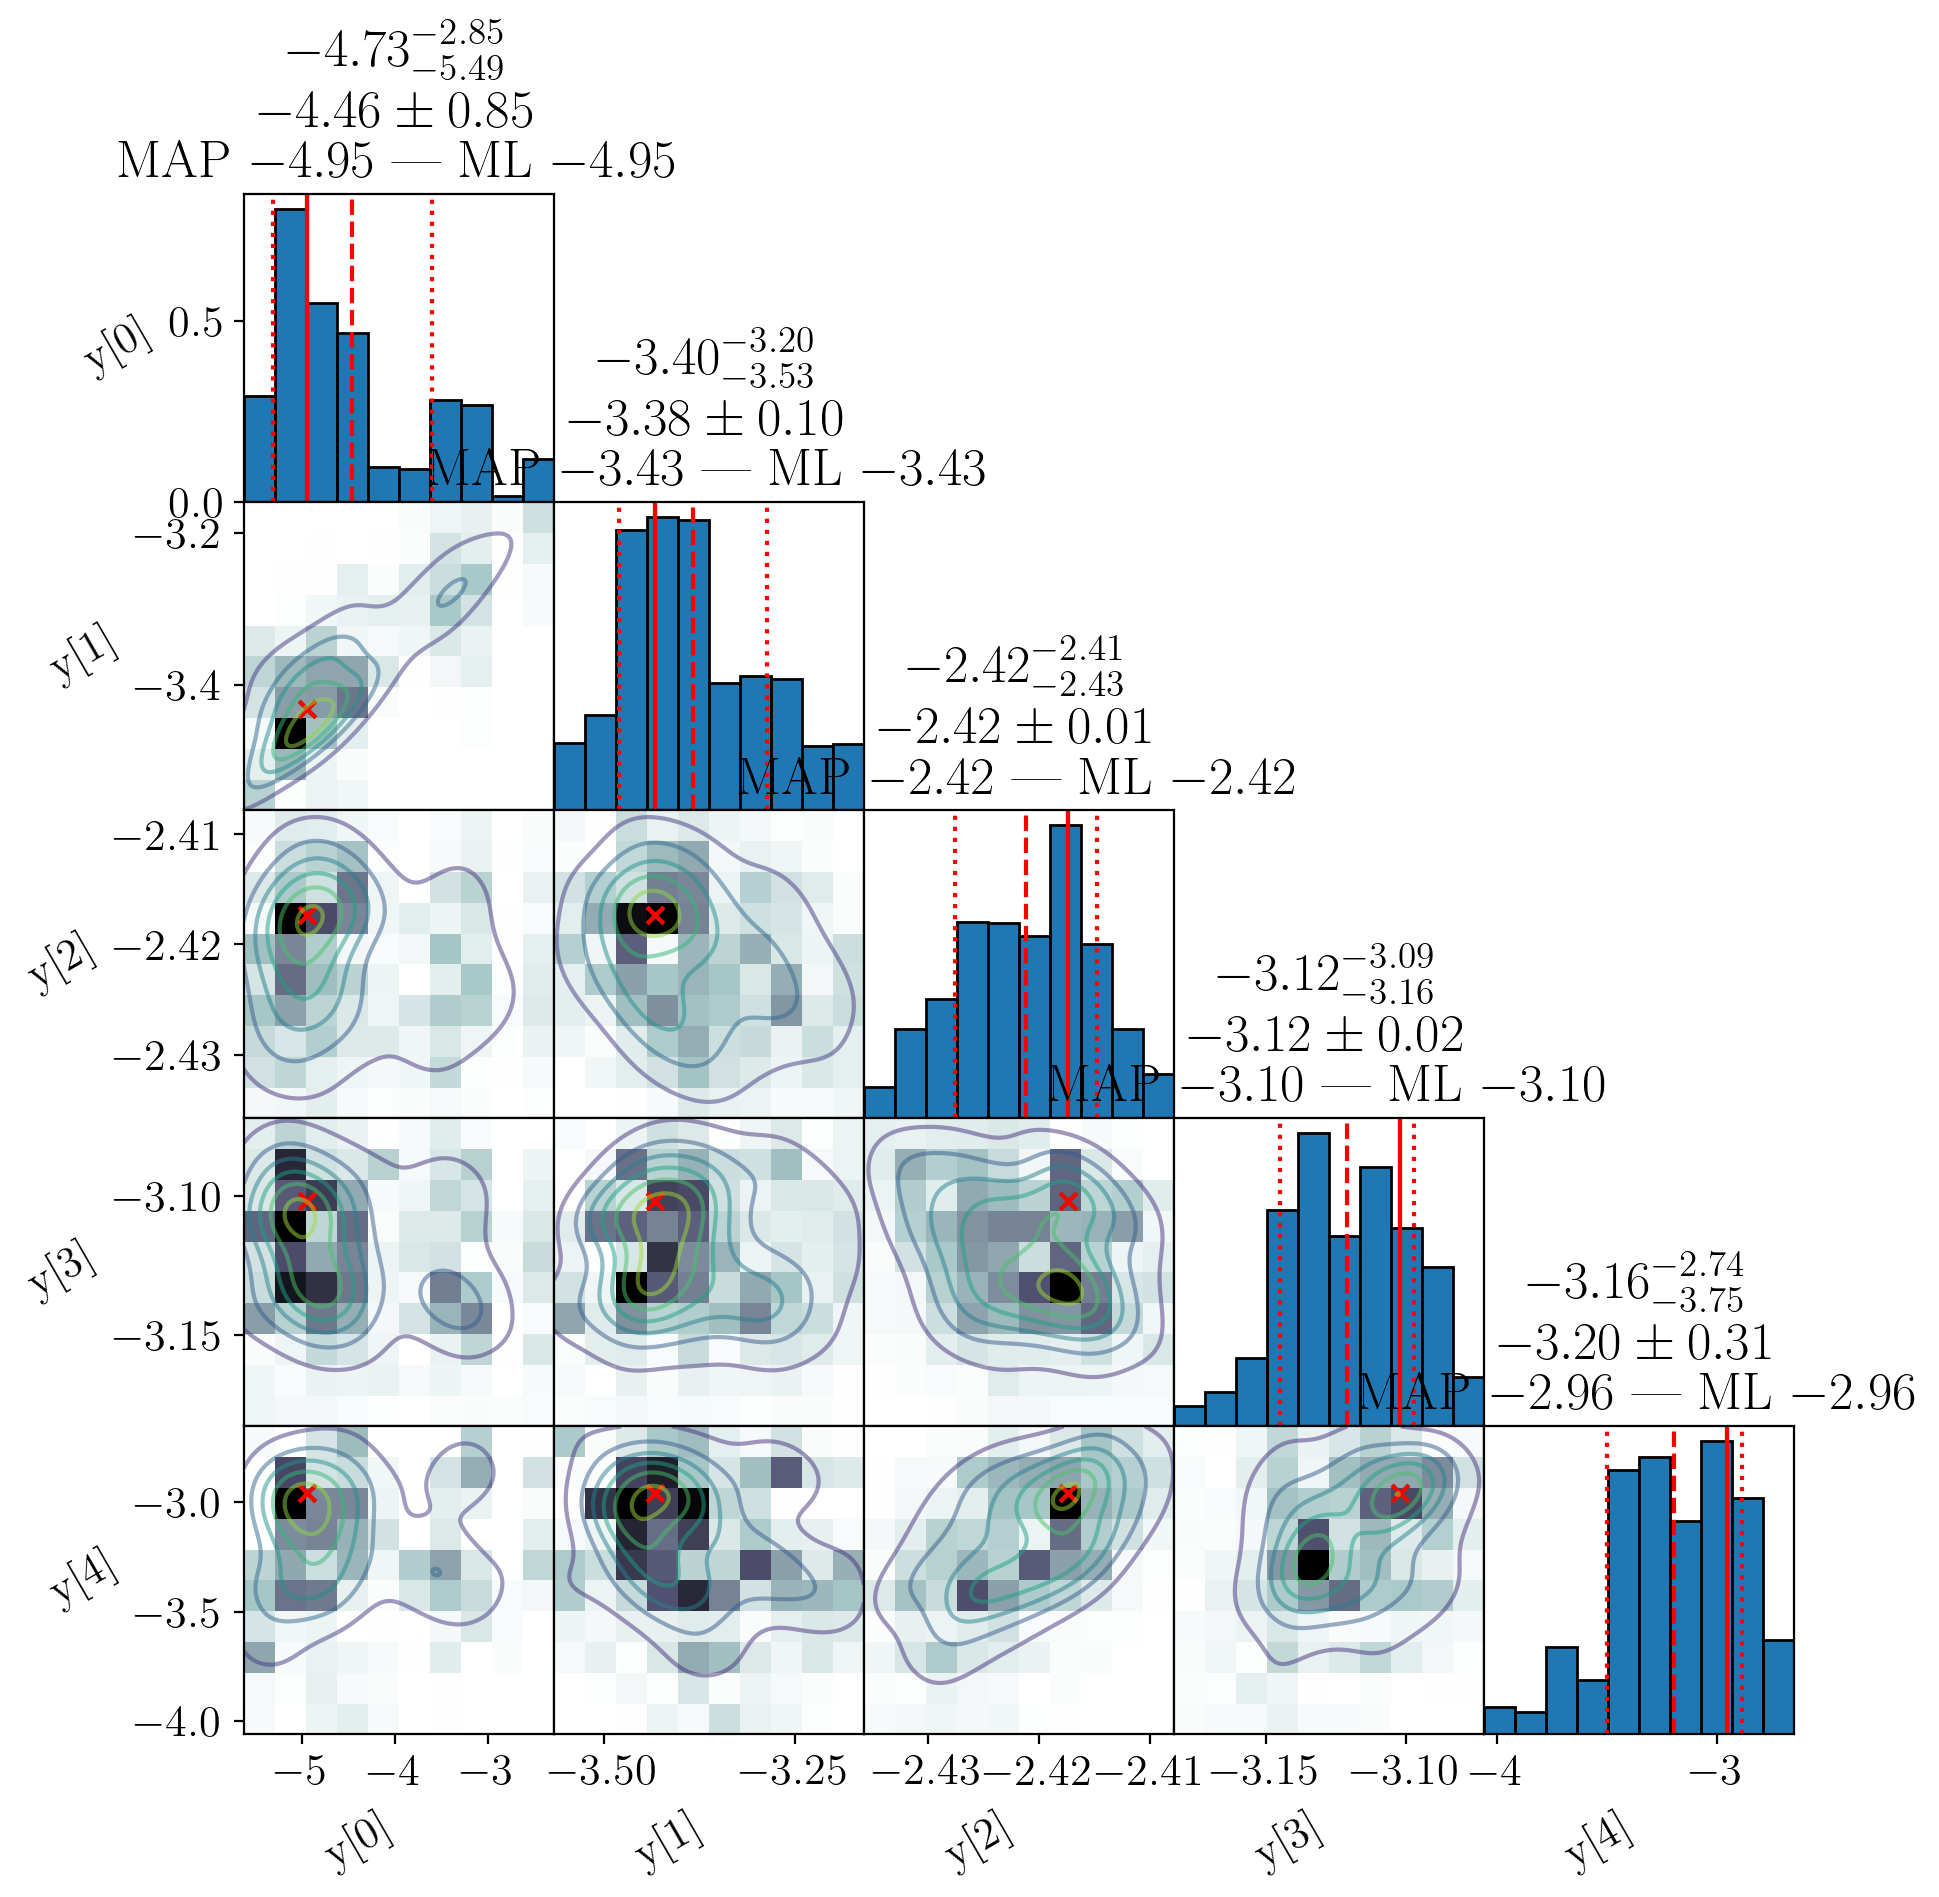

In [ ]:
exact_ns.plot_cornerplot(results,kde_overlay=True,variables=['y'])

In [ ]:
from jaxns import resample
samples =  resample(key=random.PRNGKey(0),
                        samples=results.samples,
                        log_weights=results.log_dp_mean, # type: ignore
                        replace=True,) 
print(samples.keys())
print(samples['y'].shape)

dict_keys(['y'])
(235, 5)


Text(0.5, 0, '$k$')

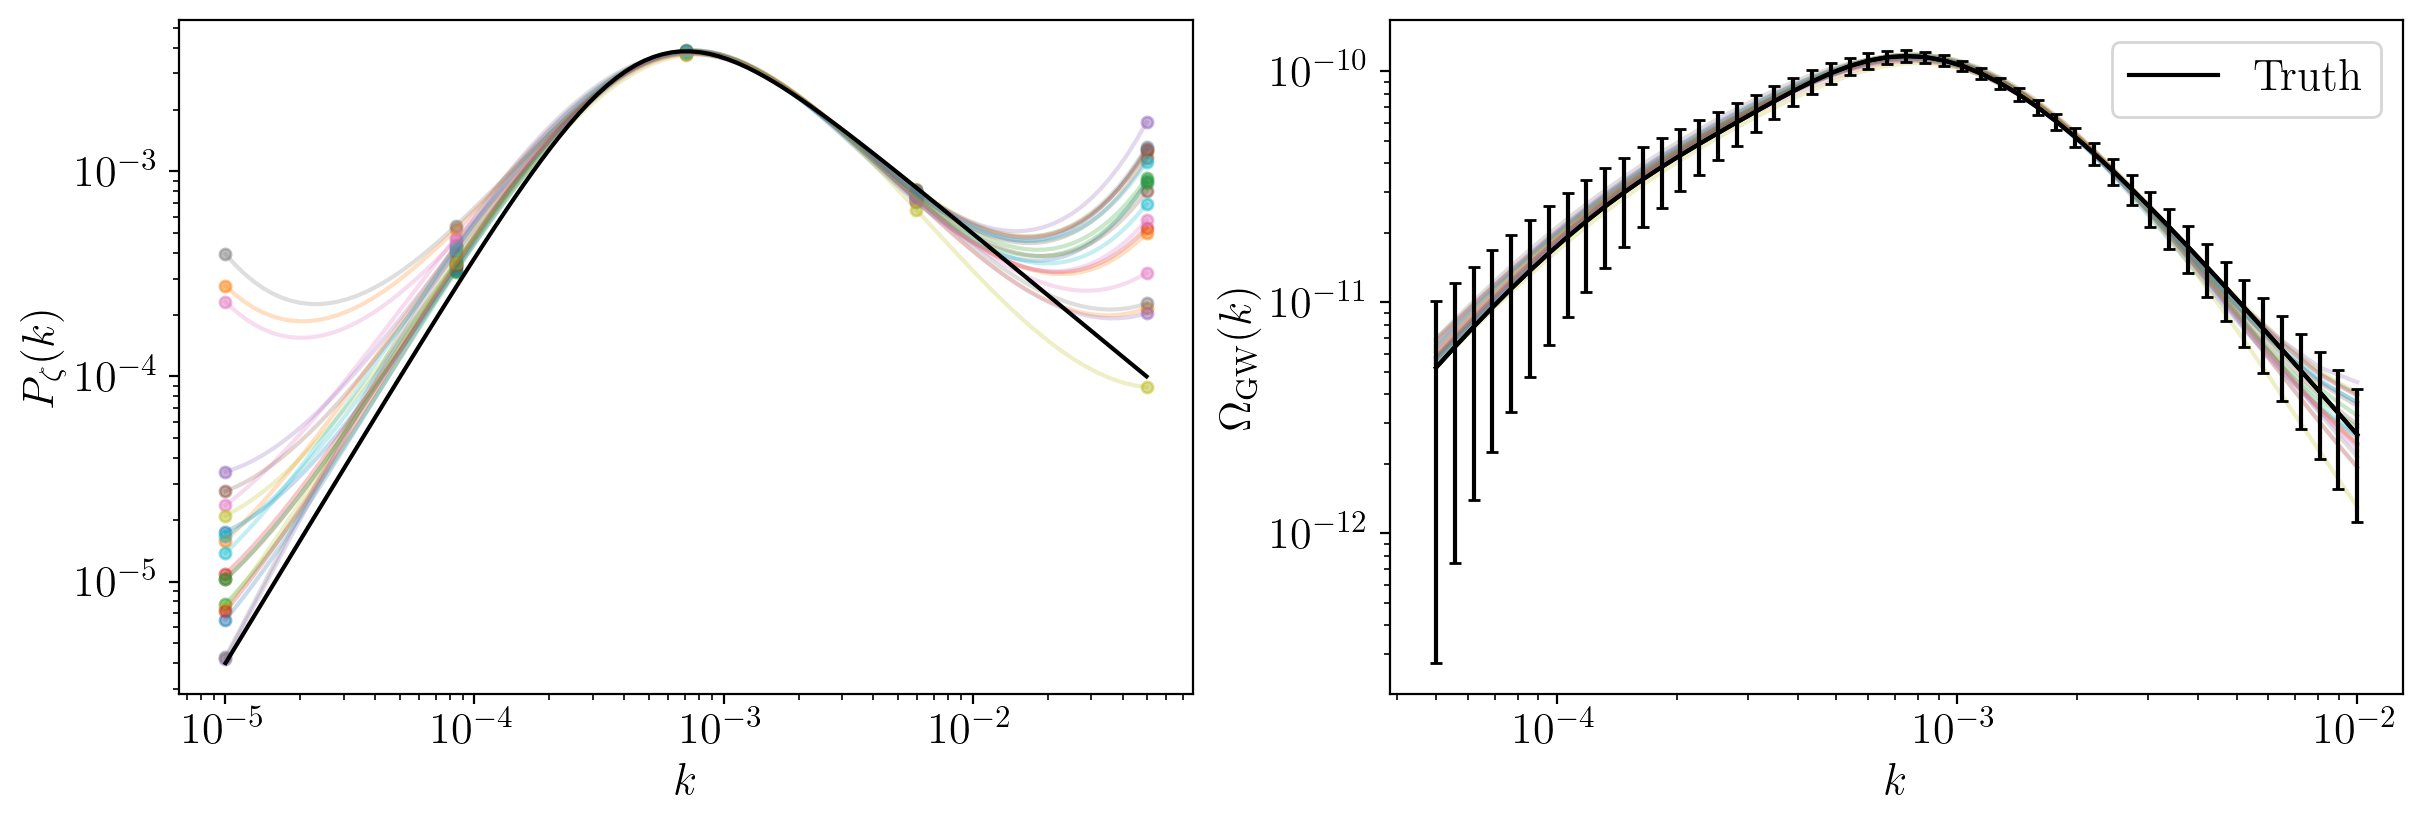

In [ ]:
### Plot the MC realisations with their logprob

from interpolation.spline import spline_predict
p_arr = jnp.geomspace(pk_min*1.001,pk_max*0.999,100,endpoint=True)

thinning = 12
cmap = matplotlib.colormaps['Reds']
ys = samples['y'][::thinning]
# xs = samples['x'][::thinning]
# lp = -extras["potential_energy"][::thinning] # PE = -negative logprob
# lp_min, lp_max = np.min(lp), np.max(lp)
# cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
# norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')

def get_pz_omega(y):
    pz = interpolator.interpolate(fixed_nodes, y)
    pz_amps = pz(p_arr)
    gwb_res = gwb_calculator(pz,frequencies)
    return pz_amps, gwb_res

pz_amps,gwb_amps = vmap(get_pz_omega)(ys)

for i,pz in enumerate(pz_amps):
    ax1.loglog(p_arr,pz,alpha=0.25)#,color=cmap(cols[i]))
    ax1.scatter(10**(fixed_nodes),10**(ys[i]),s=16,alpha=0.5)#,color=cmap(cols[i]))
for om in gwb_amps:
    ax2.loglog(frequencies,om,alpha=0.25)#,color=cmap(cols[i]))

# True pz
def pz(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    return 1e-2 * pl1 * pl2
pz_amp = pz(p_arr)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
# fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')

#### JaxNs free nodes

In [ ]:
# now test with jaxns
import tensorflow_probability.substrates.jax as tfp
from jaxns import NestedSampler, TerminationCondition
from jaxns import Model, Prior
from jaxns.framework.special_priors import ForcedIdentifiability
tfpd = tfp.distributions

s = jnp.linspace(0, 1, 15)  # First rescaled internal momentum
t = jnp.logspace(-5,5, 150)  # Second rescaled internal momentum
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(frequencies), axis=-1)

# from jax.sharding import PartitionSpec as P, NamedSharding, Mesh
# from jax.experimental import mesh_utils
    
# # mesh2d = jax.make_mesh((8, 1), ('x', 'y'))
# # devices = mesh_utils.create_device_mesh((jax.device_count(),))  # 1D mesh
# # # Step 2: Create a mesh and named sharding strategy
# # mesh = Mesh(devices, axis_names=('x',))  # Name the axis "x"
# # sharding = NamedSharding(mesh, P('x'))  # Distribute along 'x'
# # s = jnp.linspace(0, 1, 96)  # First rescaled internal momentum
# # ss = jax.device_put(s, sharding) #NamedSharding(mesh1d, P('x')))
# # s = jnp.linspace(0, 1, 25)
# # t = jnp.logspace(-5,5, 1800)  # Second rescaled internal momentum
# # freqs = jnp.array(frequencies)
# # ## Expand t to add a new axis
# # t_expanded = jnp.expand_dims(t, axis=-1)
# # ## Repeat t along the new axis to match the shape (ns,nt)
# # t = jnp.repeat(t_expanded, len(freqs), axis=-1)


gwb_calculator = OmegaGWjax(s,t,frequencies,norm="RD",kernel="RD")


# num_nodes = 4
# pk_min, pk_max = min(p_arr), max(p_arr) # jnp.array(min(frequencies)/fac), jnp.array(max(frequencies)*fac)
# pk_min, pk_max = jnp.array(min(frequencies)/5), jnp.array(max(frequencies)*5)
# interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=True,fixed_nodes=None,num_nodes=num_nodes)
num_nodes = 4
free_nodes = num_nodes - 2
pk_min, pk_max = min(p_arr), max(p_arr)
left_node, right_node = np.log10(pk_min), np.log10(pk_max)
y_low = -6
y_high = -2

from interpax import CubicSpline

def interpolate(nodes,vals,x):
    # nodes = jnp.pad(nodes, (1,1), 'constant', constant_values=(left_node, right_node))
    spl = CubicSpline(nodes,vals,check=False)
    res = jnp.power(10,spl(x))
    res = jnp.where(x<left_node, 0, res)
    res = jnp.where(x>right_node, 0, res)
    return res

def get_gwb(nodes,vals):
    pf = lambda k: interpolate(nodes,vals,jnp.log10(k))
    omegagw = gwb_calculator(pf,frequencies)
    return omegagw


get_gwb_func = jax.jit(get_gwb)

def prior():
    x = yield ForcedIdentifiability(n=num_nodes, low=left_node, high=right_node, name='x',fix_left=True,fix_right=True)
    y = yield Prior(tfpd.Uniform(low=y_low*jnp.ones(num_nodes), high=y_high*jnp.ones(num_nodes)), name='y')
    return x, y

def likelihood(x, y):
    # pf = interpolator.interpolate(x,y)
    # gwb = gwb_calculator(pf,frequencies)
    gwb = get_gwb_func(x,y)
    diff = gwb-Omegas
    return -0.5*jnp.dot(diff,jnp.linalg.solve(cov,diff))  #tfp.distributions.Normal(gwb, jnp.sqrt(jnp.diag(cov))).log_prob(Omegas).sum()

model = Model(prior, likelihood)
model.sanity_check(key=random.PRNGKey(0),S=100)

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


In [ ]:
exact_ns = NestedSampler(model=model, max_samples=1e5,parameter_estimation=True,verbose=False,difficult_model=True)

termination_reason, state = exact_ns(random.PRNGKey(42),term_cond=TerminationCondition(dlogZ=0.1,evidence_uncert=0.01))
results = exact_ns.to_results(termination_reason=termination_reason, state=state)
exact_ns.summary(results)

Running over 8 devices.


E0317 09:41:14.944377   51049 collective_ops_utils.h:310] This thread has been waiting for 5000ms for and may be stuck: participant AllGatherParticipantData{rank=5, devices=[0, 1, 2, 3, 4, 5, 6, 7], source_buffer=0x128048600, destination_buffer=0x2b944b180, chunk_size=10944} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1613, global_devices=[0,1,2,3,4,5,6,7], num_local_participants=8, collective_op_kind=cross_module, op_id=6}
E0317 09:41:16.341778   51049 collective_ops_utils.h:313] Thread is unstuck! Warning above was a false-positive. Perhaps the timeout is too short: participant AllGatherParticipantData{rank=5, devices=[0, 1, 2, 3, 4, 5, 6, 7], source_buffer=0x128048600, destination_buffer=0x2b944b180, chunk_size=10944} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1613, global_devices=[0,1,2,3,4,5,6,7], num_local_participants=8, collective_op_kind=cross_module, op_id=6}
E0317 09:43:15.493650   51049 collective_op

In [ ]:
# exact_ns.plot_diagnostics(results)

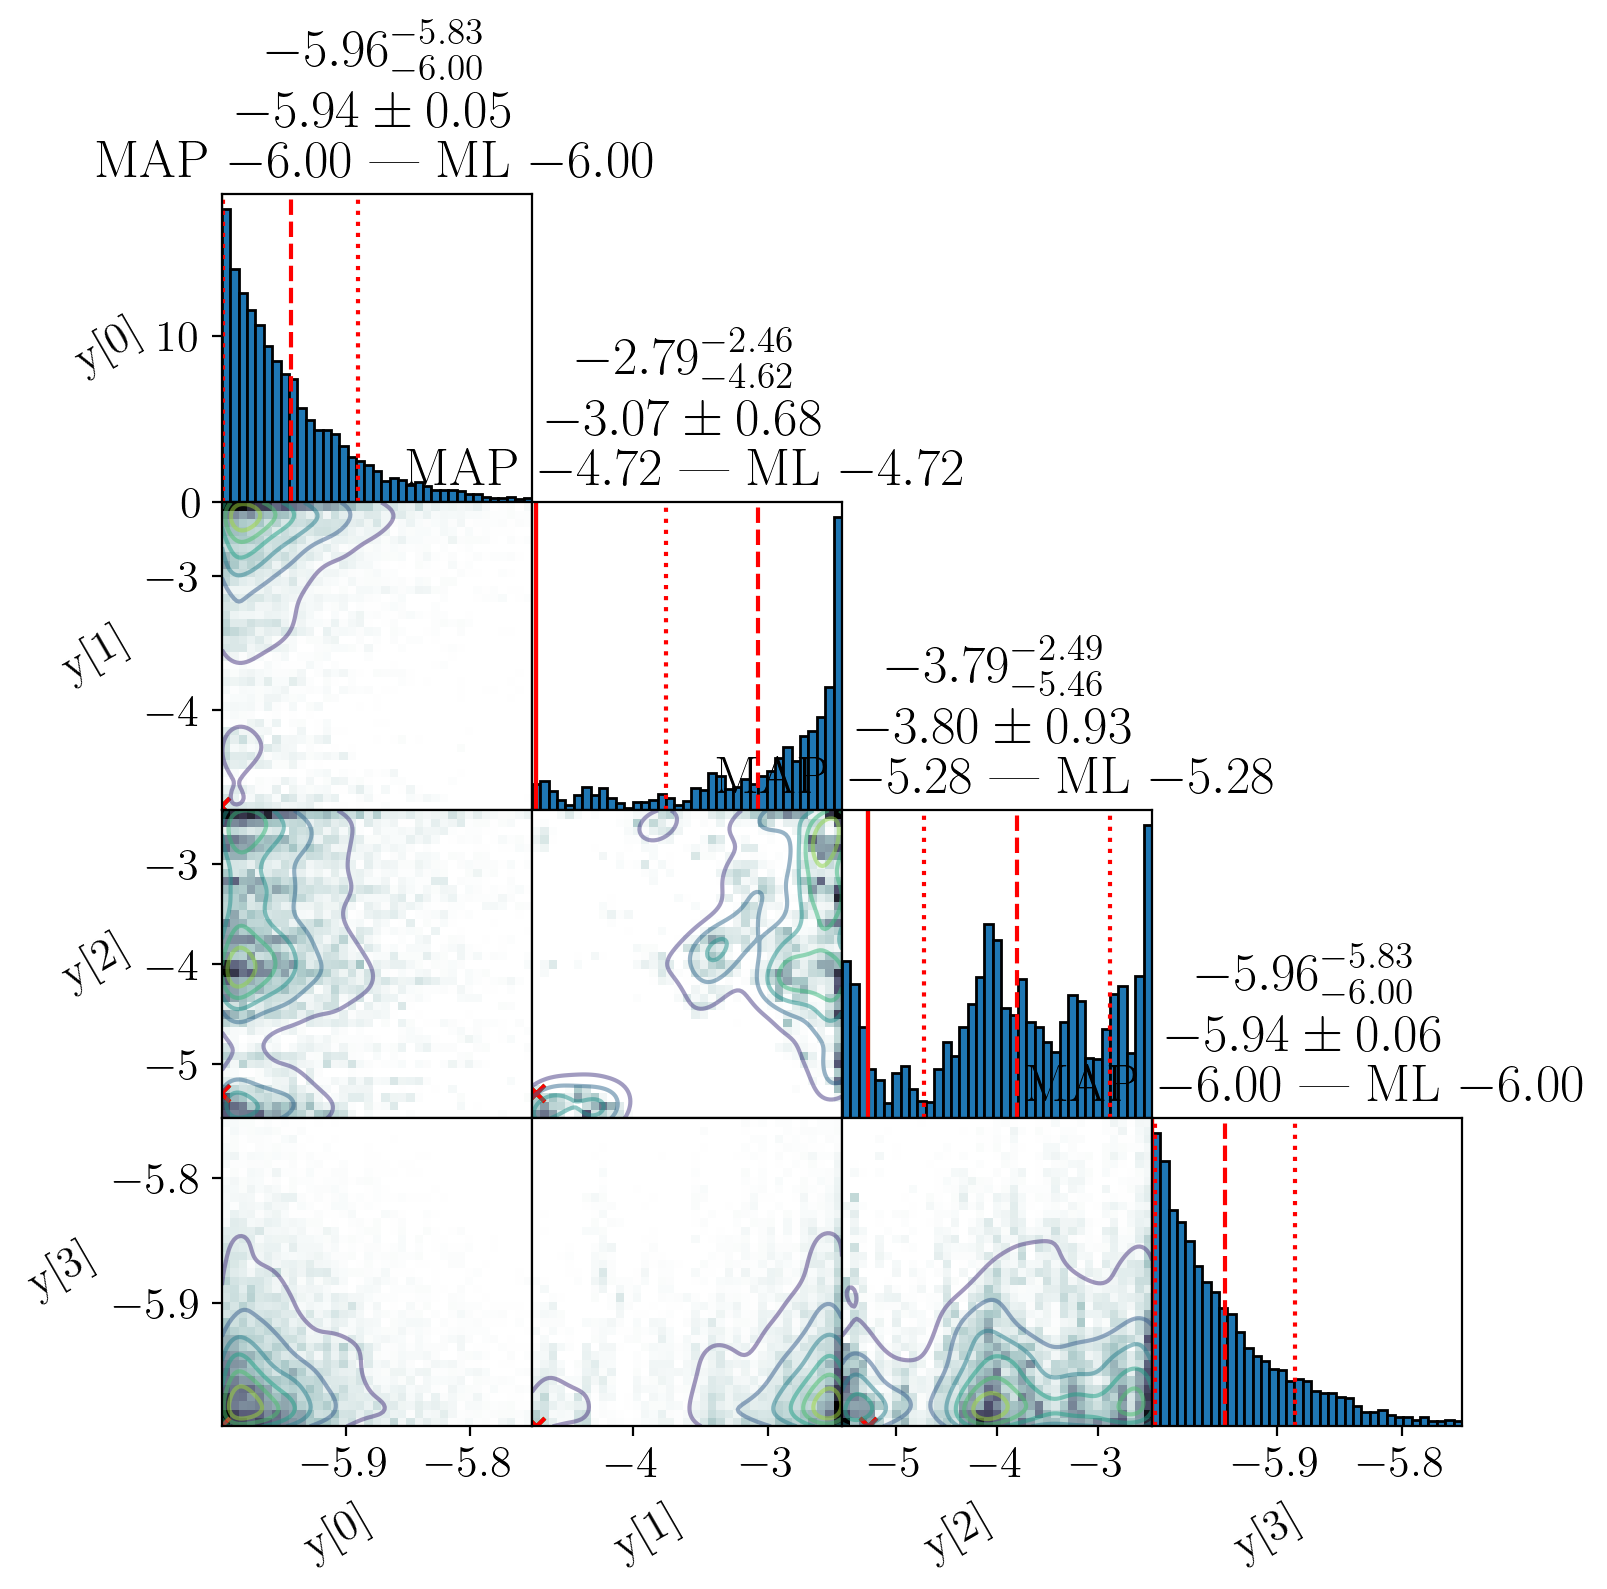

In [ ]:
exact_ns.plot_cornerplot(results,kde_overlay=True,variables=['y'])

In [ ]:

from scipy.special import logsumexp

samples = results.samples
logwts = results.log_dp_mean

def renormalise_log_weights(log_weights):
    log_total = logsumexp(log_weights)
    normalized_weights = np.exp(log_weights - log_total)
    return normalized_weights

weights = renormalise_log_weights(logwts)

print(len(samples['y']))

thinning_factor = len(samples['y']) // 64
xs = samples['x'][::thinning_factor]
ys = samples['y'][::thinning_factor]
ws = weights[::thinning_factor]

print(len(xs))

np.savez('jaxns_bpl_free_4.npz',samples = samples,weights=weights)

75088
65


In [ ]:
# get equally weighted samples

from jaxns import resample
samples =  resample(key=random.PRNGKey(2),
                        samples=results.samples,
                        log_weights=results.log_dp_mean, # type: ignore
                        replace=True,) 

thinning_factor = len(samples['y']) // 64
xs = samples['x'][::thinning_factor]
ys = samples['y'][::thinning_factor]
ws = weights[::thinning_factor]

(65, 100)
(65, 50)


<ErrorbarContainer object of 3 artists>

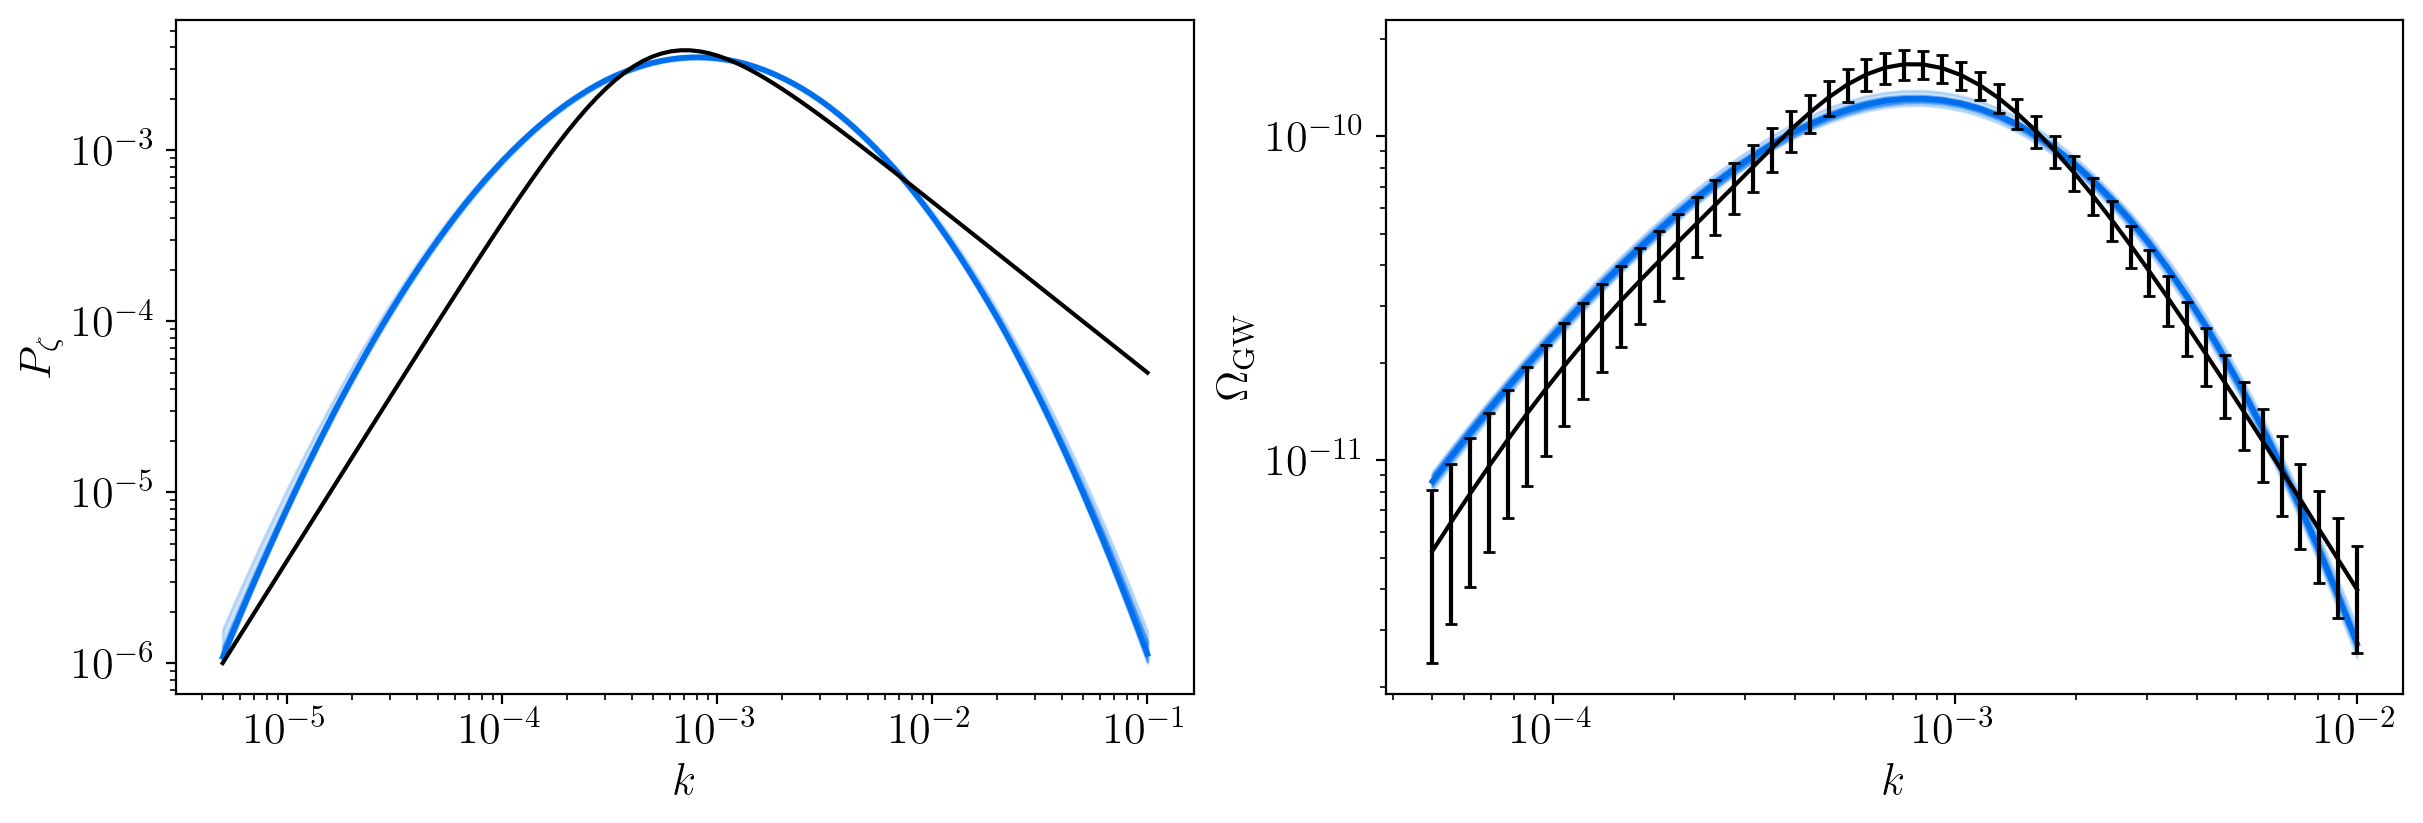

In [ ]:
# Plot the functional posterior



def plot_functional_posterior(vals = [], weights = [],k_arr = [], intervals = [95,68]
                              ,ylabels=[r'$P_{\zeta}$',r'$\Omega_{\rm GW}$'],aspect_ratio = (6,4)
                              , interval_cols = [('#006FED',0.2),('#006FED',0.5)]):
    # given a function y = f(k|x) with x~Posterior samples, plot the posterior of y at k_arr, with symmetric credible intervals

    nfuncs = len(vals)

    if weights is None:
        weights = np.ones_like(vals[0])

    # Normalize the weights so that they sum to 1
    weights /= np.sum(weights)

    fig, ax = plt.subplots(1,nfuncs,figsize=(aspect_ratio[0]*nfuncs,aspect_ratio[1]),constrained_layout=True)
    if nfuncs == 1:
        ax = [ax]
    for i,val in enumerate(vals):
        for j,interval in enumerate(intervals):
            y_low, y_high = np.percentile(val,[50-interval/2,50+interval/2],axis=0)#,weights=weights,method='inverted_cdf')
            ax[i].fill_between(k_arr[i],y_low,y_high,color=interval_cols[j])
        ax[i].plot(k_arr[i],np.median(val,axis=0),color='#006FED',lw=2)
        ax[i].set_ylabel(ylabels[i])
    for x in ax:
        x.set(xscale='log',yscale='log',xlabel=r'$k$')
    return fig, ax 


gd_colors = ['#006FED', '#E03424']


from utils  import split_vmap

def get_pz_omega(x,y):
    pz = interpolator.interpolate(x, y)
    pz_amps = pz(p_arr)
    gwb_res = gwb_calculator(pz,frequencies)
    return pz_amps, gwb_res


# thinning = samples['y'].shape[0] // 256
# xs, ys = samples['x'][::thinning], samples['y'][::thinning]
pz_amps,gwb_amps = split_vmap(get_pz_omega,(xs,ys),batch_size=10) #vmap(get_pz_omega)(xs,ys)

print(pz_amps.shape)
print(gwb_amps.shape)

# colors = 

fig, ax = plot_functional_posterior([pz_amps,gwb_amps],k_arr=[p_arr,frequencies],aspect_ratio=(6,4))
ax[0].loglog(p_arr,pz_amp,color='k',lw=1.5)
ax[1].errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')



In [ ]:
# from jaxns import resample
# samples =  resample(key=random.PRNGKey(0),
#                         samples=results.samples,
#                         log_weights=results.log_dp_mean, # type: ignore
#                         replace=True,) 
# print(samples.keys())
# print(samples['y'].shape)

dict_keys(['x', 'y'])
(17, 5)


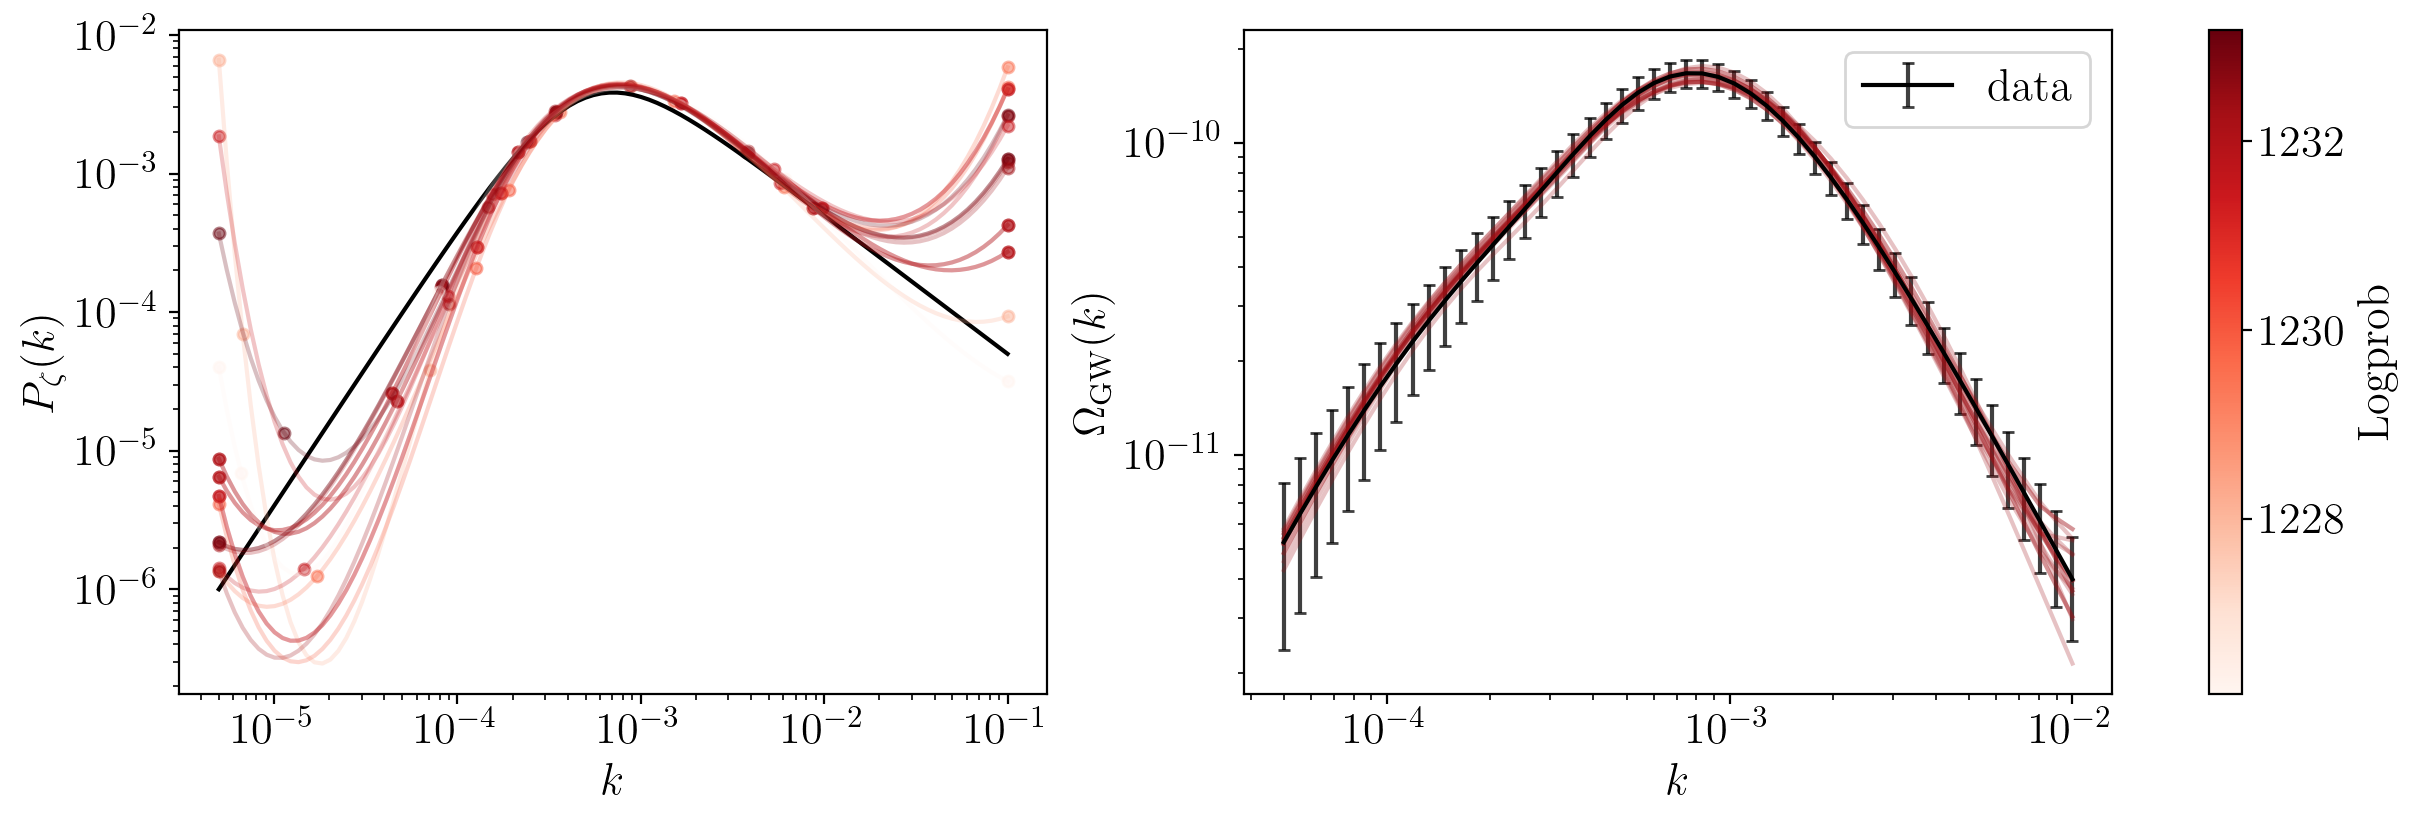

In [ ]:
# ### Plot the MC realisations with their logprob

# from interpolation.spline import spline_predict
# # p_arr = jnp.geomspace(pk_min*1.001,pk_max*0.999,100,endpoint=True)

# thinning = samples['y'].shape[0] // 16
# cmap = matplotlib.colormaps['Reds']
# ys = samples['y'][::thinning]
# xs = samples['x'][::thinning]
# lp = vmap(likelihood)(xs,ys)
# # lp = -extras["potential_energy"][::thinning] # PE = -negative logprob
# lp_min, lp_max = np.min(lp), np.max(lp)
# cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
# norm = colors.Normalize(lp_min,lp_max)

# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')
# ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
# # ax2.loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')
# ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor=('k', 0.75))

# def get_pz_omega(x,y):
#     pz = interpolator.interpolate(x, y)
#     pz_amps = pz(p_arr)
#     gwb_res = gwb_calculator(pz,frequencies)
#     return pz_amps, gwb_res

# pz_amps,gwb_amps = vmap(get_pz_omega)(xs,ys)

# for i,pz in enumerate(pz_amps):
#     ax1.loglog(p_arr,pz,alpha=0.25,color=cmap(cols[i]))
#     ax1.scatter(10**(xs[i]),10**(ys[i]),s=16,alpha=0.5,color=cmap(cols[i]))
# for om in gwb_amps:
#     ax2.loglog(frequencies,om,alpha=0.25,color=cmap(cols[i]))


# ax2.legend()
# ax1.set_ylabel(r'$P_{\zeta}(k)$')
# ax1.set_xlabel(r'$k$')

# ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
# ax2.set_xlabel(r'$k$')
# fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')

(9, 100)
(9, 50)


<ErrorbarContainer object of 3 artists>

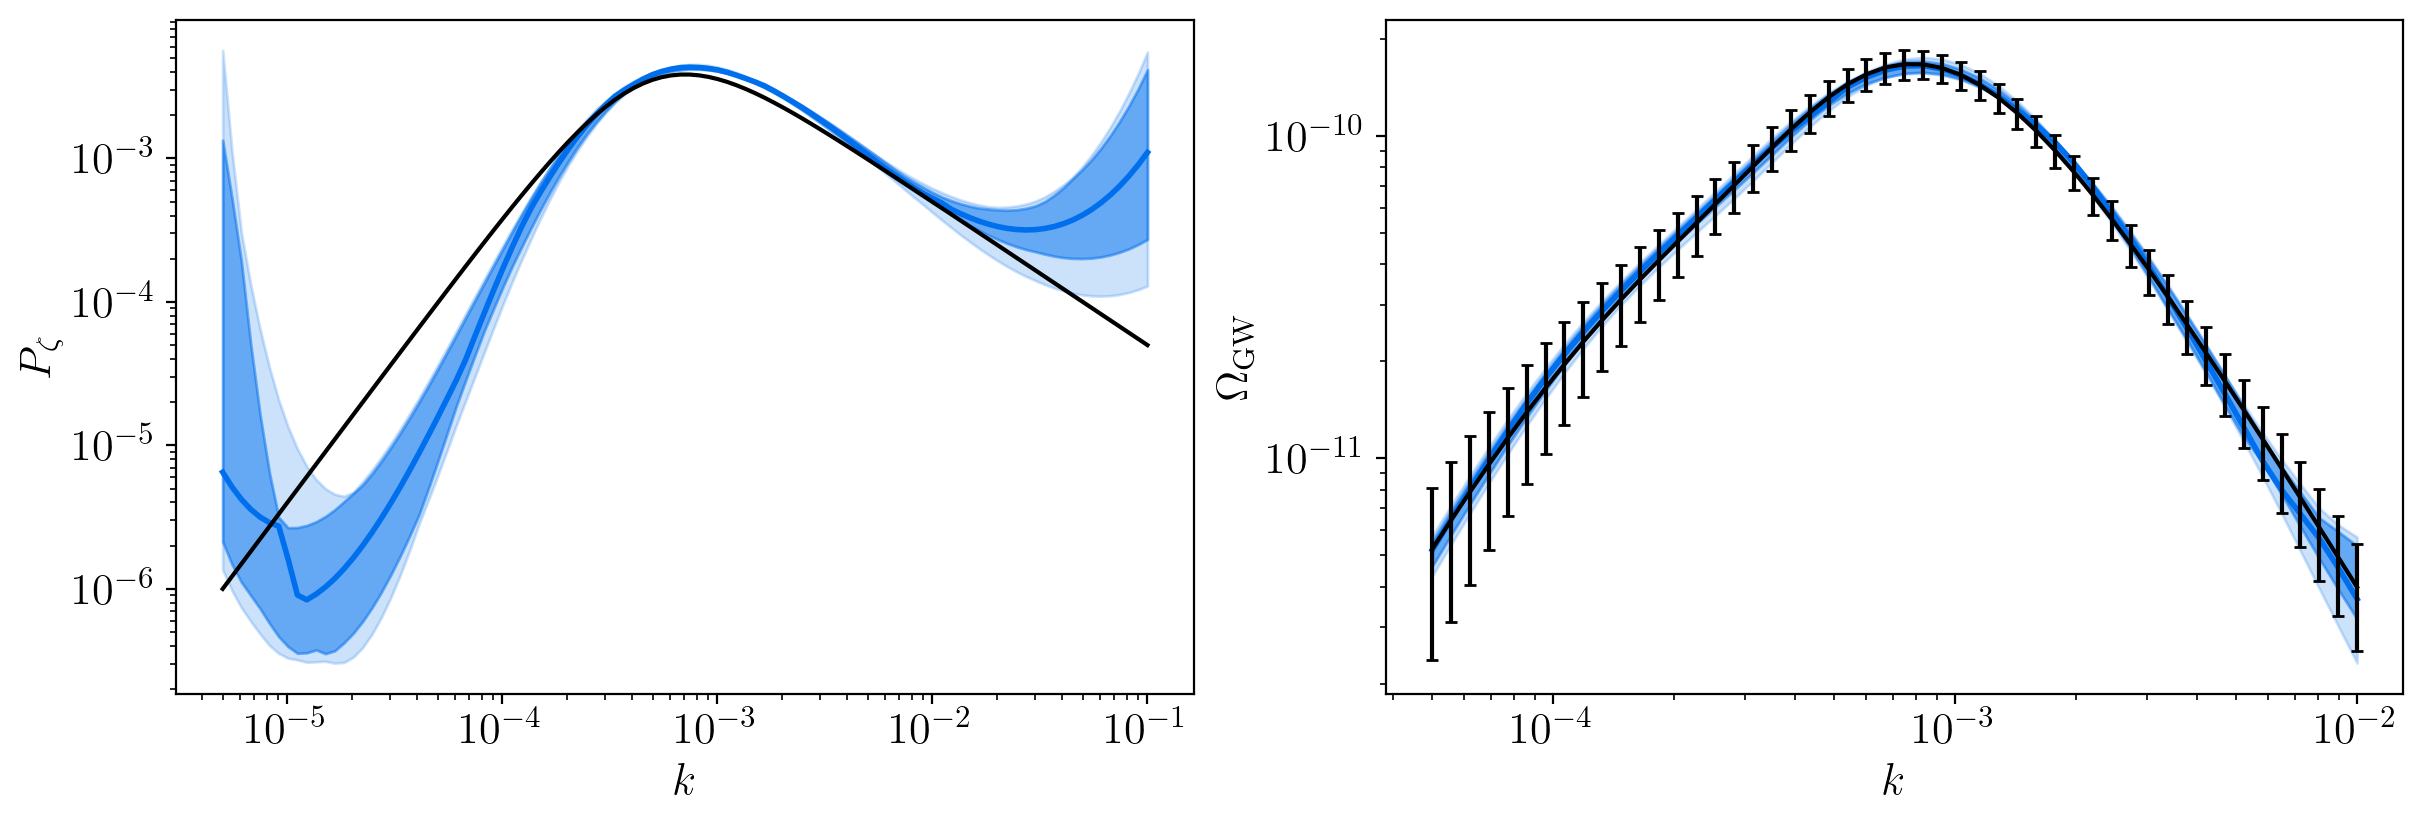

In [ ]:
# Plot the functional posterior

# print(len(samples['values']))

def plot_functional_posterior(vals = [],k_arr = [], intervals = [95,68],ylabels=[r'$P_{\zeta}$',r'$\Omega_{\rm GW}$'],aspect_ratio = (6,4), interval_cols = [('#006FED',0.2),('#006FED',0.5)]):
    # given a function y = f(k|x) with x~Posterior samples, plot the posterior of y at k_arr, with symmetric credible intervals

    nfuncs = len(vals)

    fig, ax = plt.subplots(1,nfuncs,figsize=(aspect_ratio[0]*nfuncs,aspect_ratio[1]),constrained_layout=True)
    if nfuncs == 1:
        ax = [ax]
    for i,val in enumerate(vals):
        for j,interval in enumerate(intervals):
            y_low, y_high = np.percentile(val,[50-interval/2,50+interval/2],axis=0)
            ax[i].fill_between(k_arr[i],y_low,y_high,color=interval_cols[j])
        ax[i].plot(k_arr[i],np.median(val,axis=0),color='#006FED',lw=2)
        ax[i].set_ylabel(ylabels[i])
    for x in ax:
        x.set(xscale='log',yscale='log',xlabel=r'$k$')
    return fig, ax 


gd_colors = ['#006FED', '#E03424']

def get_pz_omega(x,y):
    pz = interpolator.interpolate(x, y)
    pz_amps = pz(p_arr)
    gwb_res = gwb_calculator(pz,frequencies)
    return pz_amps, gwb_res


thinning = samples['y'].shape[0] // 256
xs, ys = samples['x'][::thinning], samples['y'][::thinning]
pz_amps,gwb_amps = vmap(get_pz_omega)(xs,ys)

print(pz_amps.shape)
print(gwb_amps.shape)

# colors = 

fig, ax = plot_functional_posterior([pz_amps,gwb_amps],k_arr=[p_arr,frequencies],aspect_ratio=(6,4))
ax[0].loglog(p_arr,pz_amp,color='k',lw=1.5)
ax[1].errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

